In [1]:
import pandas as pd
import numpy as np
import mne
from mne.time_frequency import psd_array_welch
from pymatreader import read_mat
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro
import seaborn as sns
import pylab
import scipy
from itertools import product
from scipy.stats import iqr
import warnings
from mne import create_info
from mne.io import RawArray
from mne.viz.topomap import _add_colorbar
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Functions

In [2]:
def plot_values_topomap(value_dict, montage, axes, mask, mask_params, colorbar=True, cmap='GnBu',
                        vmin=None, vmax=None, names=None, image_interp='linear', side_cb="right",
                        sensors=True, show_names=True, format='%2.1e', cbar_title='', **kwargs):
    if names is None:
        names = montage.ch_names

    info = create_info(names, sfreq=256, ch_types="eeg")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        RawArray(np.zeros((len(names), 1)), info, copy=None, verbose=False).set_montage(montage)

    im = plot_topomap([value_dict[ch] for ch in names], pos=info, show=False, image_interp=image_interp,
                      sensors=sensors, res=64, axes=axes, names=None, mask=mask, mask_params=mask_params, cmap=cmap, vlim=(vmin,vmax),**kwargs)

    if colorbar:
        try:
            cbar, cax = _add_colorbar(axes, im[0], cmap, pad=.05,
                                      format=format, side=side_cb)
            axes.cbar = cbar
            cbar.ax.tick_params(labelsize=14)
            cax.set_ylabel(cbar_title,fontsize=14)

        except TypeError:
            pass

    return im

In [3]:
def wilcox_stat_fun(x, y, axis=0):
    return 1/stats.wilcoxon(x,y,axis=axis)[0]

In [4]:
def get_channel_index_for_band(cluster, ind_band):
    return cluster[:,cluster[1]==ind_band][0]

## Reading in the psd_dfs dataframe

In [32]:
psd_dfs = pd.read_csv('/Users/lina_01/Desktop/ab_ica/psd_dfs.csv')
psd_dfs['log10_psd'] = np.log(psd_dfs['psd'])

bands = {'delta':(2,4), 'theta':(4,6), 'low_alpha':(6,9), 'high_alpha':(9,13), 'beta':(13,30), 'gamma':(30,50)}
for band_name, band in bands.items():
    psd_dfs.loc[(psd_dfs['freq']>=band[0]) & (psd_dfs['freq']<band[1]),'freq_band'] = band_name

## Topomap figures

In [33]:
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
info = mne.create_info(montage.ch_names, sfreq=500, ch_types='eeg')
raw = mne.io.RawArray(np.zeros([129,1]), info).set_montage(montage)
channel_names = montage.ch_names

Creating RawArray with float64 data, n_channels=129, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


In [34]:
adj_matrix = mne.channels.find_ch_adjacency(raw.info, ch_type='eeg')[0]
adj_matrix = mne.stats.combine_adjacency(adj_matrix, 6)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 129


In [35]:
threshold = 434

In [36]:
mask_params = dict(markersize=10, markerfacecolor="y")

### Eye movements

#### Cluster-based permutation analysis

In [37]:
psd_dfs_saccade = psd_dfs.loc[(psd_dfs['seg_type']=='saccade')]
psd_dfs_saccade_means = psd_dfs_saccade.groupby(['subject_age', 'channel', 'kind', 'seg_type','freq','freq_band'])\
                                       .mean().reset_index().drop(columns='Unnamed: 0')

In [38]:
original_logs = psd_dfs_saccade_means.loc[psd_dfs_saccade_means['kind']=='original']['log10_psd'].values
ab_logs = psd_dfs_saccade_means.loc[psd_dfs_saccade_means['kind']=='AB']['log10_psd'].values
ica_logs = psd_dfs_saccade_means.loc[psd_dfs_saccade_means['kind']=='ICA']['log10_psd'].values

diff_AB = np.subtract(original_logs, ab_logs)
diff_ICA = np.subtract(original_logs, ica_logs)

psd_dfs_saccade_means_ab = psd_dfs_saccade_means.loc[psd_dfs_saccade_means['kind']=='AB']
psd_dfs_saccade_means_ab['diff_AB'] = diff_AB

psd_dfs_saccade_means_ica = psd_dfs_saccade_means.loc[psd_dfs_saccade_means['kind']=='ICA']
psd_dfs_saccade_means_ica['diff_ICA'] = diff_ICA

X_saccade_ab_ica = []

for band in bands.keys():
    psd_dfs_saccade_means_bands_ab = psd_dfs_saccade_means_ab.loc[(psd_dfs_saccade_means_ab['freq_band']==band)]
    psd_dfs_saccade_means_bands_ab = psd_dfs_saccade_means_bands_ab[['diff_AB','subject_age','channel']]
    psd_dfs_saccade_means_bands_ab = np.array(psd_dfs_saccade_means_bands_ab.pivot_table(index='subject_age', 
                                                                                       columns='channel', values='diff_AB'))
    
    psd_dfs_saccade_means_bands_ica = psd_dfs_saccade_means_ica.loc[(psd_dfs_saccade_means_ica['freq_band']==band)]
    psd_dfs_saccade_means_bands_ica = psd_dfs_saccade_means_bands_ica[['diff_ICA','subject_age','channel']]
    psd_dfs_saccade_means_bands_ica = np.array(psd_dfs_saccade_means_bands_ica.pivot_table(index='subject_age', 
                                                                                                     columns='channel', 
                                                                                                     values='diff_ICA'))
    X_saccade_ab_ica.append([psd_dfs_saccade_means_bands_ica, psd_dfs_saccade_means_bands_ab])

X_saccade_ab_ica = np.array(X_saccade_ab_ica).transpose([1,2,3,0])

/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_2416/1544592370.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psd_dfs_saccade_means_ab['diff_AB'] = diff_AB
/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_2416/1544592370.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psd_dfs_saccade_means_ica['diff_ICA'] = diff_ICA


In [39]:
w, clusters, clusters_pv, h0 = mne.stats.permutation_cluster_test(X_saccade_ab_ica, threshold = 1/threshold, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun, adjacency=adj_matrix)

stat_fun(H1): min=0.001570 max=0.007407
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

#### Extracting significant channels to plot

In [40]:
mask_dict = {}

for ind_band in range(6):
    significant_channels = []
    for cluster in clusters:   
        cluster = np.stack(cluster)
        channel_index = get_channel_index_for_band(cluster, ind_band)
        significant_channels.extend(channel_index)
        
    significant_channels = sorted(significant_channels)
    
    mask = np.zeros((129,),dtype='bool')
    for ch in significant_channels:
        mask[ch] = True
    mask_dict[ind_band] = mask

#### Calculating differences between AB and ICA for topomap

In [41]:
psd_dfs_subsets = []
for band in list(bands.keys()):
    psd_dfs_saccade_band = psd_dfs_saccade.loc[psd_dfs_saccade['freq_band']==band]
    psd_dfs_subsets.append(psd_dfs_saccade_band)

diffs_list = []
for i in range(len(psd_dfs_subsets)):
    df = psd_dfs_subsets[i]
    diffs_ica = np.abs(df.loc[df['kind']=='original']['log10_psd'].values - df.loc[df['kind']=='ICA']['log10_psd'].values)
    diffs_ab = np.abs(df.loc[df['kind']=='original']['log10_psd'].values - df.loc[df['kind']=='AB']['log10_psd'].values)
    diffs = diffs_ab - diffs_ica
    diffs_list.append(diffs)



#### Dictionary of PSD differences by channel

In [42]:
dict_topomaps = []
for i in range(len(diffs_list)):
    channel_array = psd_dfs_subsets[i].channel.unique()
    dict_topomap=dict(zip(channel_array, diffs_list[i]))
    dict_topomaps.append(dict_topomap)

dict_topomaps_reordered = []
for subset in range(len(dict_topomaps)):
    reordered_dict = {}
    for ch in channel_names:
        reordered_dict[ch]=dict_topomaps[subset][ch]
    dict_topomaps_reordered.append(reordered_dict)

#### Plotting topomap

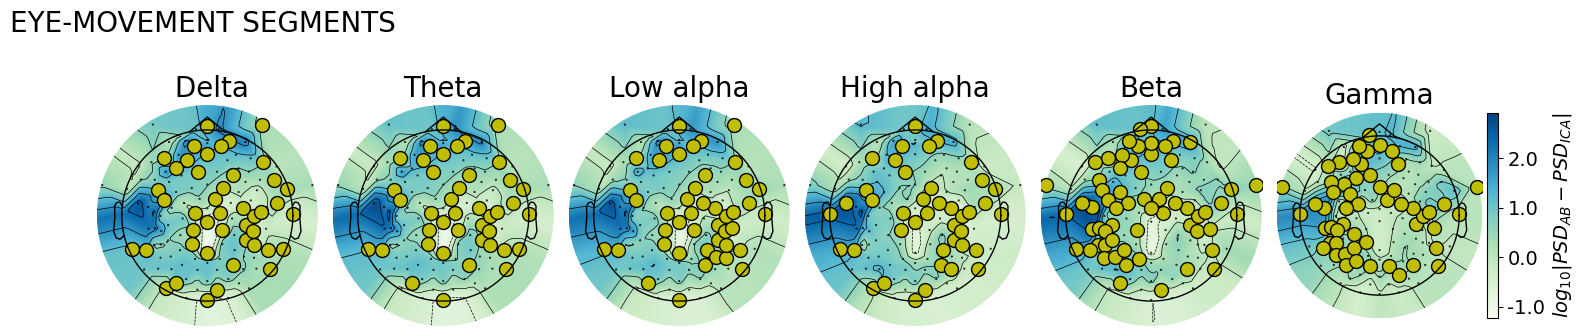

In [50]:
fig, axes = plt.subplots(1,6,figsize=(15,6))

vmins = []
vmaxes = []

for i in range(len(dict_topomaps_reordered)):
    vmin = min(dict_topomaps_reordered[i].values())
    vmax = max(dict_topomaps_reordered[i].values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)

for i in range(5):
    plot_values_topomap(dict_topomaps_reordered[i], montage, axes[i], mask_dict[i], mask_params, names=channel_names, vmin=vmin1, 
                        vmax=vmax1,format='%2.1f', colorbar=False)

plot_values_topomap(dict_topomaps_reordered[5], montage, axes[5], mask=mask_dict[5], mask_params=mask_params, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=True, cbar_title='$log_{10}|PSD_{AB}-PSD_{ICA}|$')

axes[0].set_title('EYE-MOVEMENT SEGMENTS \n \n Delta',fontsize=20)
axes[1].set_title('Theta',fontsize=20)
axes[2].set_title('Low alpha',fontsize=20)
axes[3].set_title('High alpha',fontsize=20)
axes[4].set_title('Beta',fontsize=20)
axes[5].set_title('Gamma',fontsize=20)

fig.tight_layout()

plt.savefig('figS1a.png', facecolor='white',bbox_inches='tight')

#### Plotting topomaps separately

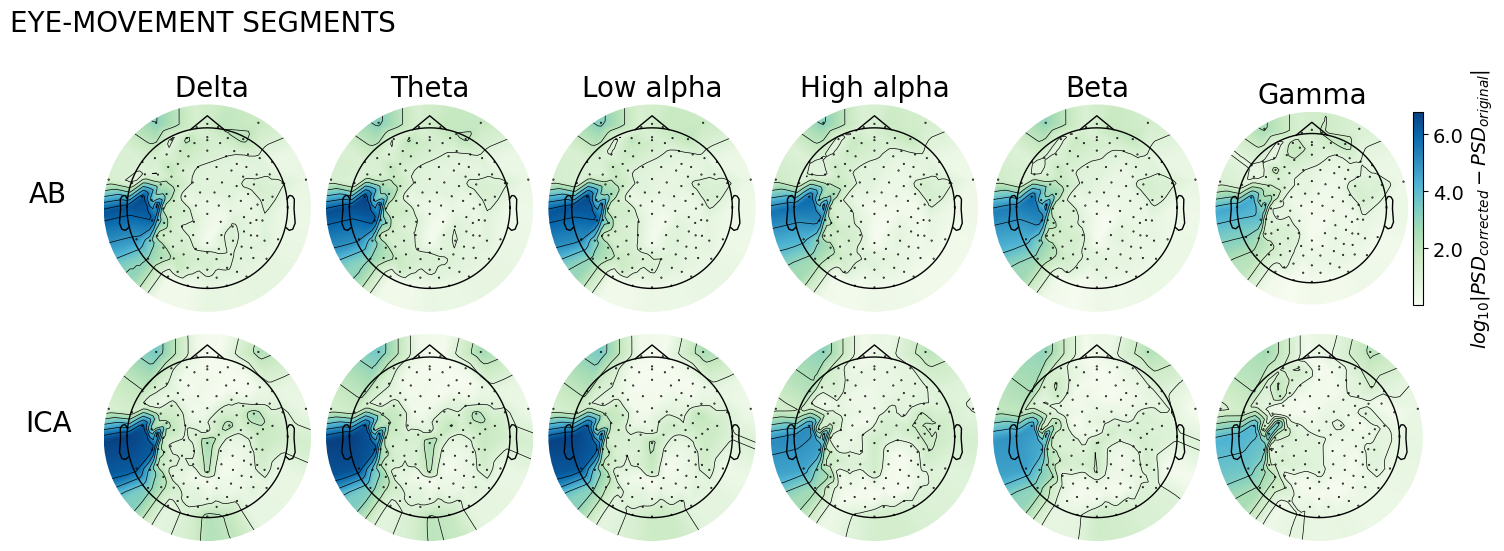

In [51]:
diffs_list = []
for i in range(len(psd_dfs_subsets)):
    df = psd_dfs_subsets[i]
    diffs = np.abs(df.loc[df['kind']=='original']['log10_psd'].values - df.loc[df['kind']=='AB']['log10_psd'].values)
    diffs_list.append(diffs)

dict_topomaps = []
for i in range(len(diffs_list)):
    channel_array = psd_dfs_subsets[i].channel.unique()
    dict_topomap=dict(zip(channel_array, diffs_list[i]))
    dict_topomaps.append(dict_topomap)

dict_topomaps_reordered = []
for subset in range(len(dict_topomaps)):
    reordered_dict = {}
    for ch in channel_names:
        reordered_dict[ch]=dict_topomaps[subset][ch]
    dict_topomaps_reordered.append(reordered_dict)

vmins = []
vmaxes = []
for i in range(len(dict_topomaps_reordered)):
    vmin = min(dict_topomaps_reordered[i].values())
    vmax = max(dict_topomaps_reordered[i].values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)

fig, axes = plt.subplots(2,6,figsize=(15,6))

for i in range(5):
    plot_values_topomap(dict_topomaps_reordered[i], montage, axes[0][i], mask=None, mask_params=None, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)

plot_values_topomap(dict_topomaps_reordered[5], montage, axes[0][5], mask=None, mask_params=None, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=True, cbar_title='$log_{10}|PSD_{corrected}-PSD_{original}|$')

diffs_list = []
for i in range(len(psd_dfs_subsets)):
    df = psd_dfs_subsets[i]
    diffs = np.abs(df.loc[df['kind']=='original']['log10_psd'].values - df.loc[df['kind']=='ICA']['log10_psd'].values)
    diffs_list.append(diffs)

dict_topomaps = []
for i in range(len(diffs_list)):
    channel_array = psd_dfs_subsets[i].channel.unique()
    dict_topomap=dict(zip(channel_array, diffs_list[i]))
    dict_topomaps.append(dict_topomap)

dict_topomaps_reordered = []
for subset in range(len(dict_topomaps)):
    reordered_dict = {}
    for ch in channel_names:
        reordered_dict[ch]=dict_topomaps[subset][ch]
    dict_topomaps_reordered.append(reordered_dict)

vmins = []
vmaxes = []
for i in range(len(dict_topomaps_reordered)):
    vmin = min(dict_topomaps_reordered[i].values())
    vmax = max(dict_topomaps_reordered[i].values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)

for i in range(6):
    plot_values_topomap(dict_topomaps_reordered[i], montage, axes[1][i], mask=None, mask_params=None, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)


axes[0][0].set_title('EYE-MOVEMENT SEGMENTS \n \n Delta',fontsize=20)
axes[0][1].set_title('Theta',fontsize=20)
axes[0][2].set_title('Low alpha',fontsize=20)
axes[0][3].set_title('High alpha',fontsize=20)
axes[0][4].set_title('Beta',fontsize=20)
axes[0][5].set_title('Gamma',fontsize=20)

axes[0][0].set_ylabel('AB', labelpad=40, rotation = 'horizontal',fontsize=20, loc='center')
axes[1][0].set_ylabel('ICA', labelpad=40, rotation = 'horizontal',fontsize=20, loc='center')

fig.tight_layout()

plt.savefig('fig5a.png', facecolor='white',bbox_inches='tight')

### Clean

#### Cluster based permutation test

In [55]:
psd_dfs_clean = psd_dfs.loc[(psd_dfs['seg_type']=='clean')]
psd_dfs_clean_means = psd_dfs_clean.groupby(['subject_age', 'channel', 'kind', 'seg_type','freq','freq_band'])\
                                       .mean().reset_index().drop(columns='Unnamed: 0')

In [56]:
original_logs = psd_dfs_clean_means.loc[psd_dfs_clean_means['kind']=='original']['log10_psd'].values
ab_logs = psd_dfs_clean_means.loc[psd_dfs_clean_means['kind']=='AB']['log10_psd'].values
ica_logs = psd_dfs_clean_means.loc[psd_dfs_clean_means['kind']=='ICA']['log10_psd'].values

diff_AB = np.subtract(original_logs, ab_logs)
diff_ICA = np.subtract(original_logs, ica_logs)

psd_dfs_clean_means_ab = psd_dfs_clean_means.loc[psd_dfs_clean_means['kind']=='AB']
psd_dfs_clean_means_ab['diff_AB'] = diff_AB

psd_dfs_clean_means_ica = psd_dfs_clean_means.loc[psd_dfs_clean_means['kind']=='ICA']
psd_dfs_clean_means_ica['diff_ICA'] = diff_ICA

X_clean_ab_ica = []

for band in bands.keys():
    psd_dfs_clean_means_bands_ab = psd_dfs_clean_means_ab.loc[(psd_dfs_clean_means_ab['freq_band']==band)]
    psd_dfs_clean_means_bands_ab = psd_dfs_clean_means_bands_ab[['diff_AB','subject_age','channel']]
    psd_dfs_clean_means_bands_ab = np.array(psd_dfs_clean_means_bands_ab.pivot_table(index='subject_age', 
                                                                                       columns='channel', values='diff_AB'))
    
    psd_dfs_clean_means_bands_ica = psd_dfs_clean_means_ica.loc[(psd_dfs_clean_means_ica['freq_band']==band)]
    psd_dfs_clean_means_bands_ica = psd_dfs_clean_means_bands_ica[['diff_ICA','subject_age','channel']]
    psd_dfs_clean_means_bands_ica = np.array(psd_dfs_clean_means_bands_ica.pivot_table(index='subject_age', 
                                                                                                     columns='channel', 
                                                                                                     values='diff_ICA'))
    X_clean_ab_ica.append([psd_dfs_clean_means_bands_ica, psd_dfs_clean_means_bands_ab])

X_clean_ab_ica = np.array(X_clean_ab_ica).transpose([1,2,3,0])

/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_2416/563095153.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psd_dfs_clean_means_ab['diff_AB'] = diff_AB
/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_2416/563095153.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psd_dfs_clean_means_ica['diff_ICA'] = diff_ICA


In [57]:
w, clusters, clusters_pv, h0 = mne.stats.permutation_cluster_test(X_clean_ab_ica, threshold = 1/threshold, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun, adjacency=adj_matrix)

stat_fun(H1): min=0.001570 max=0.011628
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

#### Extracting significant channels to plot

In [58]:
mask_dict = {}

for ind_band in range(6):
    significant_channels = []
    for cluster in clusters:   
        cluster = np.stack(cluster)
        channel_index = get_channel_index_for_band(cluster, ind_band)
        significant_channels.extend(channel_index)
        
    significant_channels = sorted(significant_channels)
    
    mask = np.zeros((129,),dtype='bool')
    for ch in significant_channels:
        mask[ch] = True
    mask_dict[ind_band] = mask

#### Calculating differences between AB and ICA for topomap

In [59]:
psd_dfs_subsets = []
for band in list(bands.keys()):
    psd_dfs_clean_band = psd_dfs_clean.loc[psd_dfs_clean['freq_band']==band]
    psd_dfs_subsets.append(psd_dfs_clean_band)

diffs_list = []
for i in range(len(psd_dfs_subsets)):
    df = psd_dfs_subsets[i]
    diffs_ica = np.abs(df.loc[df['kind']=='original']['log10_psd'].values - df.loc[df['kind']=='ICA']['log10_psd'].values)
    diffs_ab = np.abs(df.loc[df['kind']=='original']['log10_psd'].values - df.loc[df['kind']=='AB']['log10_psd'].values)
    diffs = diffs_ab - diffs_ica
    diffs_list.append(diffs)

#### Dictionary of PSD differences by channel

In [60]:
dict_topomaps = []
for i in range(len(diffs_list)):
    channel_array = psd_dfs_subsets[i].channel.unique()
    dict_topomap=dict(zip(channel_array, diffs_list[i]))
    dict_topomaps.append(dict_topomap)

dict_topomaps_reordered = []
for subset in range(len(dict_topomaps)):
    reordered_dict = {}
    for ch in channel_names:
        reordered_dict[ch]=dict_topomaps[subset][ch]
    dict_topomaps_reordered.append(reordered_dict)

#### Plotting topomap

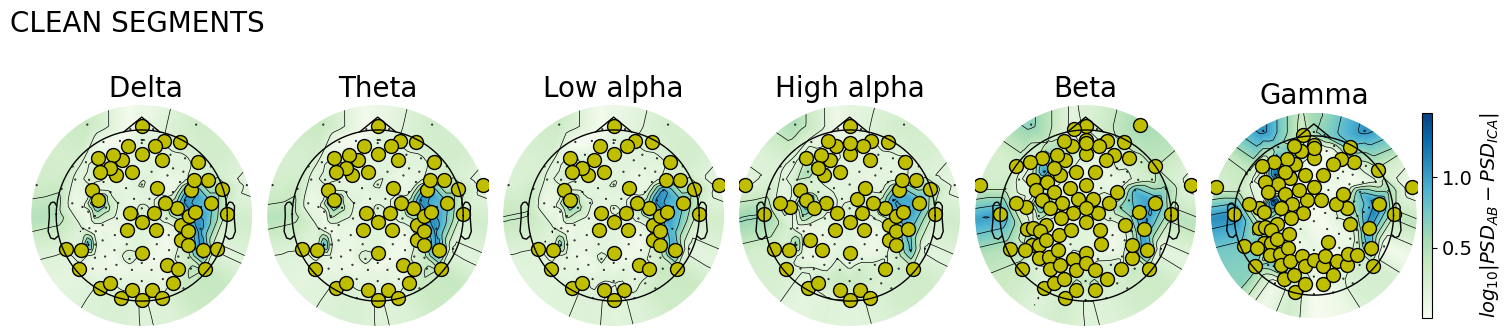

In [69]:
fig, axes = plt.subplots(1,6,figsize=(15,6))

vmins = []
vmaxes = []

for i in range(len(dict_topomaps_reordered)):
    vmin = min(dict_topomaps_reordered[i].values())
    vmax = max(dict_topomaps_reordered[i].values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)

for i in range(5):
    plot_values_topomap(dict_topomaps_reordered[i], montage, axes[i], mask_dict[i], mask_params, names=channel_names, vmin=vmin1, 
                        vmax=vmax1,format='%2.1f', colorbar=False)
plot_values_topomap(dict_topomaps_reordered[5], montage, axes[5], mask_dict[5], mask_params, names=channel_names, vmin=vmin1, 
                        vmax=vmax1,format='%2.1f', colorbar=True, cbar_title='$log_{10}|PSD_{AB}-PSD_{ICA}|$')

axes[0].set_title('CLEAN SEGMENTS \n \n Delta',fontsize=20)
axes[1].set_title('Theta',fontsize=20)
axes[2].set_title('Low alpha',fontsize=20)
axes[3].set_title('High alpha',fontsize=20)
axes[4].set_title('Beta',fontsize=20)
axes[5].set_title('Gamma',fontsize=20)

fig.tight_layout()

plt.savefig('figS1b.png', facecolor='white',bbox_inches='tight')

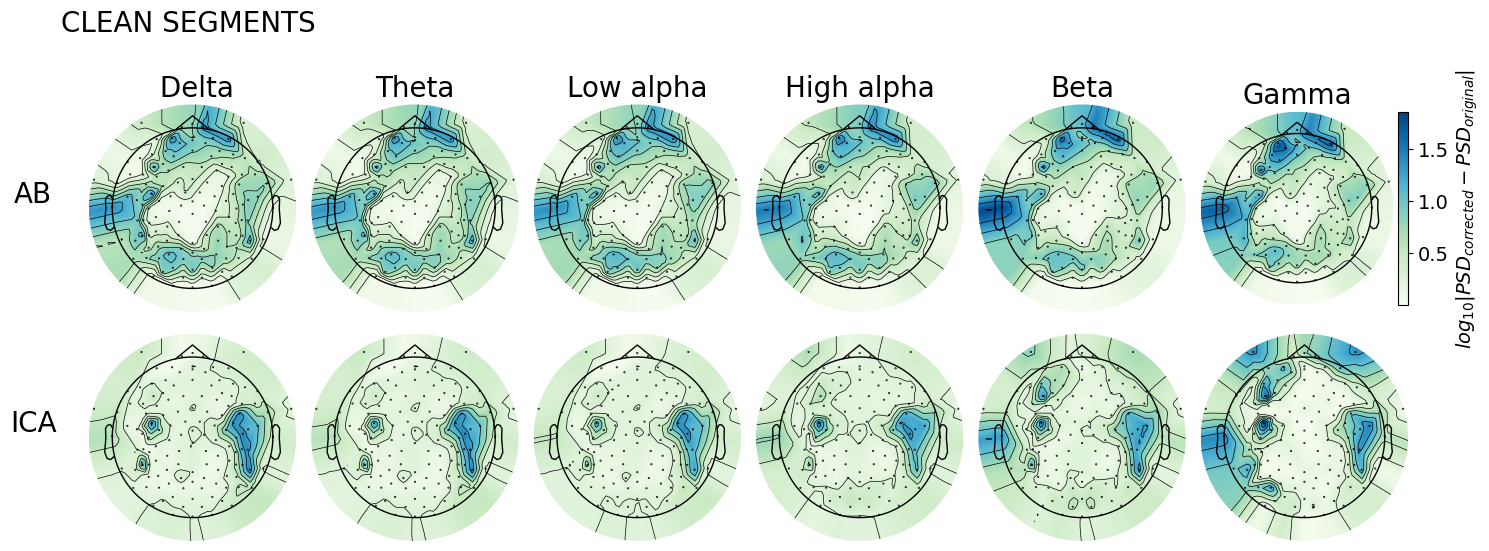

In [64]:
diffs_list = []
for i in range(len(psd_dfs_subsets)):
    df = psd_dfs_subsets[i]
    diffs = np.abs(df.loc[df['kind']=='original']['log10_psd'].values - df.loc[df['kind']=='AB']['log10_psd'].values)
    diffs_list.append(diffs)

dict_topomaps = []
for i in range(len(diffs_list)):
    channel_array = psd_dfs_subsets[i].channel.unique()
    dict_topomap=dict(zip(channel_array, diffs_list[i]))
    dict_topomaps.append(dict_topomap)

dict_topomaps_reordered = []
for subset in range(len(dict_topomaps)):
    reordered_dict = {}
    for ch in channel_names:
        reordered_dict[ch]=dict_topomaps[subset][ch]
    dict_topomaps_reordered.append(reordered_dict)

vmins = []
vmaxes = []
for i in range(len(dict_topomaps_reordered)):
    vmin = min(dict_topomaps_reordered[i].values())
    vmax = max(dict_topomaps_reordered[i].values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)

fig, axes = plt.subplots(2,6,figsize=(15,6))

for i in range(5):
    plot_values_topomap(dict_topomaps_reordered[i], montage, axes[0][i], mask=None, mask_params=None, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)

plot_values_topomap(dict_topomaps_reordered[5], montage, axes[0][5], mask=None, mask_params=None, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=True, cbar_title='$log_{10}|PSD_{corrected}-PSD_{original}|$')

diffs_list = []
for i in range(len(psd_dfs_subsets)):
    df = psd_dfs_subsets[i]
    diffs = np.abs(df.loc[df['kind']=='original']['log10_psd'].values - df.loc[df['kind']=='ICA']['log10_psd'].values)
    diffs_list.append(diffs)

dict_topomaps = []
for i in range(len(diffs_list)):
    channel_array = psd_dfs_subsets[i].channel.unique()
    dict_topomap=dict(zip(channel_array, diffs_list[i]))
    dict_topomaps.append(dict_topomap)

dict_topomaps_reordered = []
for subset in range(len(dict_topomaps)):
    reordered_dict = {}
    for ch in channel_names:
        reordered_dict[ch]=dict_topomaps[subset][ch]
    dict_topomaps_reordered.append(reordered_dict)

vmins = []
vmaxes = []
for i in range(len(dict_topomaps_reordered)):
    vmin = min(dict_topomaps_reordered[i].values())
    vmax = max(dict_topomaps_reordered[i].values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)

for i in range(6):
    plot_values_topomap(dict_topomaps_reordered[i], montage, axes[1][i], mask=None, mask_params=None, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)


axes[0][0].set_title('CLEAN SEGMENTS \n \n Delta',fontsize=20)
axes[0][1].set_title('Theta',fontsize=20)
axes[0][2].set_title('Low alpha',fontsize=20)
axes[0][3].set_title('High alpha',fontsize=20)
axes[0][4].set_title('Beta',fontsize=20)
axes[0][5].set_title('Gamma',fontsize=20)

axes[0][0].set_ylabel('AB', labelpad=40, rotation = 'horizontal',fontsize=20, loc='center')
axes[1][0].set_ylabel('ICA', labelpad=40, rotation = 'horizontal',fontsize=20, loc='center')

fig.tight_layout()

plt.savefig('fig5b.png', facecolor='white',bbox_inches='tight')

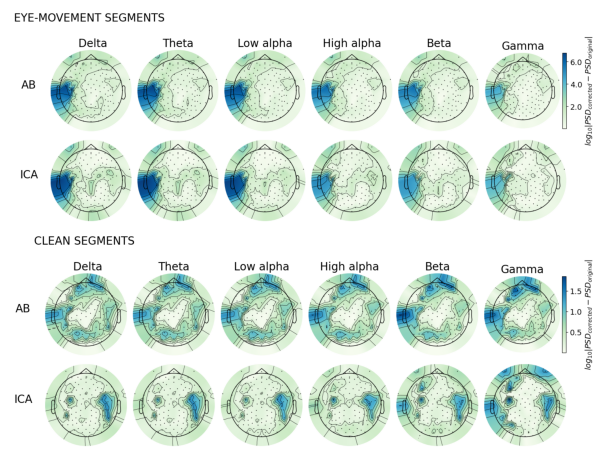

In [65]:
import matplotlib.image as mpimg
figures = ['5a','5b']
margin = 200
fig, axes = plt.subplots(2, 1, figsize=(6, 4.6))
for figure, ax in zip(figures, axes.ravel()):
    img = mpimg.imread(f"/Users/lina_01/Desktop/ab_ica/fig{figure}.png")
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set(frame_on=False)
    
    ax.imshow(img)        
    ax.set_aspect(1)    
    
fig.tight_layout(rect=[-0.01, -0.02, 1.02, 1.02], w_pad=0.0, h_pad=0.0)
fig.savefig("fig5.png", dpi=300)

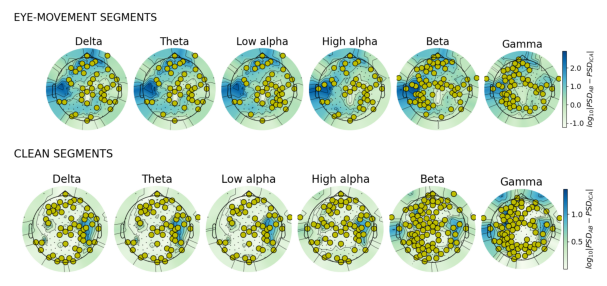

In [70]:
import matplotlib.image as mpimg
figures = ['S1a','S1b']
margin = 200
fig, axes = plt.subplots(2, 1, figsize=(6, 3))
for figure, ax in zip(figures, axes.ravel()):
    img = mpimg.imread(f"/Users/lina_01/Desktop/ab_ica/fig{figure}.png")
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set(frame_on=False)
    
    ax.imshow(img)        
    ax.set_aspect(1)    
    
fig.tight_layout(rect=[-0.01, -0.02, 1.02, 1.02], w_pad=0.0, h_pad=0.0)
fig.savefig("figS1.png", dpi=300)

In [ ]:
#put images together
#put original images together
#add to manuscript
#clean up rebuttal comments

In [ ]:
##EXTRA##

In [ ]:
ab_ica_pt_selection = pd.read_excel('/Users/lina_01/Desktop/ab_ica/AB_ICA_pt_table.xlsx'

In [ ]:
psd_dfs = []
kinds = ['original', 'AB', 'ICA']
seg_types = ['saccade', 'clean']
path = 'C:/Users/dsrish/Desktop/fieldtrip-20220208'
pts = list(ab_ica_pt_selection['pt'])

for kind in kinds:
    for pt in pts:
        annot_file = f'/Users/dsrish/Desktop/ds_msc_project/manual_annot_AB_ICA_{pt}.csv'
        for seg_type in seg_types:
            annotations = mne.read_annotations(annot_file)
            times = {}
            for annot in annotations:
                times['onset'] = np.array([annot['onset'] for annot in annotations if annot['description']==seg_type])
                times['duration'] = np.array([annot['duration'] for annot in annotations if annot['description']==seg_type])
                times['offset'] = times['onset'] + times['duration']

            crops = []
            for tmin, tmax in zip(times['onset'],times['offset']):
                if kind=='original':
                    raw_file = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_processed.fif')           

                elif kind=='AB':
                    raw_file_original = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_processed.fif')
                    AB_mat_outdata = read_mat(f'{path}/{pt}_AB_outdata.mat')
                    AB_mat_outdata = AB_mat_outdata['datatosave_out']['OutData']
                    raw_file = mne.io.RawArray(AB_mat_outdata, raw_file_original.info)

                else:
                    raw_file = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_ica.fif')
                
                crop = raw_file.crop(tmin=tmin, tmax=tmax)
                crops.append(crop)

            crop_file = mne.concatenate_raws(crops)  

            srate = raw_file.info['sfreq']
            nfft = int(srate/2)
            nperseg = int(0.5*nfft)
            overlap = int(0.25 * nfft)
            psd, freq = psd_welch(crop_file, picks='all', fmin=2, fmax=48, n_fft=nfft, n_per_seg=nperseg, n_overlap=overlap, 
                                  average='mean')
            assert(not np.any(np.isnan(psd)))
            psd = pd.DataFrame(psd)
            psd['pt'] = pt
            psd['channel'] = crop_file.ch_names
            psd['seg_type'] = seg_type
            psd['kind'] = kind
            psd.columns.values[:len(freq)] = freq
            psd_long = pd.melt(psd, id_vars=['pt','channel', 'seg_type', 'kind'], value_vars=list(psd.columns))
            psd_dfs.append(psd_long)

In [ ]:
psd_dfs = pd.concat(psd_dfs)
psd_dfs.rename(columns={'variable':'freq', 'pt':'subject_age','value':'psd'}, inplace=True)

In [ ]:
np.any(np.isnan(psd_dfs.psd))